# **Installing necessary libraries**

In [1]:
#Downloading libraries

%pip install catboost optuna seaborn scikit-learn openpyxl nbformat ipython ipywidgets lightgbm xgboost lazypredict-nightly

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing libraries and setting necessery settings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import optuna
from optuna.samplers import TPESampler
import lazypredict
from lazypredict import LazyRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, MaxAbsScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.svm import SVR
from lightgbm import LGBMRegressor, Dataset

from xgboost import XGBRegressor


%matplotlib inline
plt.style.use("seaborn-v0_8")

# **Basic EDA**

In [3]:
# Readign the file

data = pd.read_csv("final_data.csv", index_col = 0)

In [4]:
# To view some real data

data.head()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary
0,0.38,0.53,2,157.00,3.00,0,sales,low
1,0.80,0.86,5,262.00,6.00,0,sales,medium
2,0.11,0.88,7,272.00,4.00,0,sales,medium
3,0.72,0.87,5,223.00,5.00,0,sales,low
4,0.37,0.52,2,159.00,3.00,0,sales,low


In [5]:
# To understand the statistica about the data

data.describe()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted
count,21531.00,21531.00,21531.00,21531.00,21531.00,21531.00
mean,0.57,0.69,3.57,193.47,4.78,0.02
std,0.22,0.14,0.99,37.30,2.09,0.15
min,0.00,0.31,2.00,96.00,2.00,0.00
25%,0.42,0.58,3.00,179.00,3.00,0.00
50%,0.57,0.67,3.00,186.00,5.00,0.00
75%,0.74,0.78,4.00,209.00,6.00,0.00
max,1.00,1.00,7.00,310.00,12.00,1.00


In [6]:
# To know data types and null number

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21531 entries, 0 to 9539
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   satisfaction   21531 non-null  float64
 1   review         21531 non-null  float64
 2   projects       21531 non-null  int64  
 3   avg_hrs_month  21531 non-null  float64
 4   tenure         21531 non-null  float64
 5   promoted       21531 non-null  int64  
 6   department     21531 non-null  object 
 7   salary         21531 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 1.5+ MB


In [7]:
df = shuffle(data, random_state = 777)
df

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary
8917,0.59,0.82,3,162.00,2.00,0,IT,high
4664,0.38,0.78,2,182.08,6.00,0,sales,medium
7413,0.36,0.60,3,185.11,7.00,0,sales,low
9654,0.68,0.61,4,227.00,3.00,0,technical,medium
7366,0.61,0.59,4,247.00,2.00,0,technical,medium
...,...,...,...,...,...,...,...,...
4026,0.91,0.93,4,184.00,3.00,0,technical,low
7776,0.83,0.90,3,179.00,2.00,0,product_mng,low
7375,0.32,0.64,3,184.65,7.00,0,retail,medium
3940,0.33,0.83,3,178.84,5.00,0,retail,medium


# **Feature engeneering**

In [8]:
# Combining features

df['workload_intensity'] = (df['projects'] / df['tenure']) * df['avg_hrs_month']
df['relative_project_load'] = (df['projects'] / df['avg_hrs_month']) / df['tenure']
df['hours_per_project'] = df['avg_hrs_month'] / df['projects']
df['experience_weighted_promotion'] = (df['tenure'] * df['promoted']) / (df['tenure'] + 1)
df.head()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion
8917,0.59,0.82,3,162.00,2.00,0,IT,high,243.00,0.01,54.00,0.00
4664,0.38,0.78,2,182.08,6.00,0,sales,medium,60.69,0.00,91.04,0.00
7413,0.36,0.60,3,185.11,7.00,0,sales,low,79.33,0.00,61.70,0.00
9654,0.68,0.61,4,227.00,3.00,0,technical,medium,302.67,0.01,56.75,0.00
7366,0.61,0.59,4,247.00,2.00,0,technical,medium,494.00,0.01,61.75,0.00


In [9]:
# Polynomial features

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['projects', 'avg_hrs_month']])
poly_features_df = pd.DataFrame(poly_features, columns=[f'poly_{i}' for i in range(poly_features.shape[1])])
df = df.join(poly_features_df)
df.head()

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion,poly_0,poly_1,poly_2,poly_3,poly_4
8917,0.59,0.82,3,162.00,2.00,0,IT,high,243.00,0.01,54.00,0.00,4.00,134.00,16.00,536.00,17956.00
4664,0.38,0.78,2,182.08,6.00,0,sales,medium,60.69,0.00,91.04,0.00,3.00,109.00,9.00,327.00,11881.00
7413,0.36,0.60,3,185.11,7.00,0,sales,low,79.33,0.00,61.70,0.00,4.00,161.00,16.00,644.00,25921.00
9654,0.68,0.61,4,227.00,3.00,0,technical,medium,302.67,0.01,56.75,0.00,3.00,179.61,9.00,538.83,32259.59
7366,0.61,0.59,4,247.00,2.00,0,technical,medium,494.00,0.01,61.75,0.00,3.00,181.40,9.00,544.20,32905.61


In [10]:
# Encoding salary categorial column

df_encoded = df

le = LabelEncoder()
df_encoded['salary'] = le.fit_transform(df_encoded['salary'])
df_encoded

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,department,salary,workload_intensity,relative_project_load,hours_per_project,experience_weighted_promotion,poly_0,poly_1,poly_2,poly_3,poly_4
8917,0.59,0.82,3,162.00,2.00,0,IT,0,243.00,0.01,54.00,0.00,4.00,134.00,16.00,536.00,17956.00
4664,0.38,0.78,2,182.08,6.00,0,sales,2,60.69,0.00,91.04,0.00,3.00,109.00,9.00,327.00,11881.00
7413,0.36,0.60,3,185.11,7.00,0,sales,1,79.33,0.00,61.70,0.00,4.00,161.00,16.00,644.00,25921.00
9654,0.68,0.61,4,227.00,3.00,0,technical,2,302.67,0.01,56.75,0.00,3.00,179.61,9.00,538.83,32259.59
7366,0.61,0.59,4,247.00,2.00,0,technical,2,494.00,0.01,61.75,0.00,3.00,181.40,9.00,544.20,32905.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.91,0.93,4,184.00,3.00,0,technical,1,245.33,0.01,46.00,0.00,3.00,188.71,9.00,566.13,35611.30
7776,0.83,0.90,3,179.00,2.00,0,product_mng,1,268.50,0.01,59.67,0.00,3.00,195.00,9.00,585.00,38025.00
7375,0.32,0.64,3,184.65,7.00,0,retail,2,79.14,0.00,61.55,0.00,4.00,185.98,16.00,743.92,34588.21
3940,0.33,0.83,3,178.84,5.00,0,retail,2,107.31,0.00,59.61,0.00,3.00,232.00,9.00,696.00,53824.00


In [11]:
# Encoding department categorial column

ohe = OneHotEncoder(handle_unknown='ignore')
department_encoded = ohe.fit_transform(df_encoded[['department']]).toarray()
department_columns = ohe.categories_[0]
department_df = pd.DataFrame(department_encoded, columns=department_columns)
df_encoded = df_encoded.join(department_df)
df_encoded = df_encoded.drop('department', axis=1)
df_encoded

,satisfaction,review,projects,avg_hrs_month,tenure,promoted,salary,workload_intensity,relative_project_load,hours_per_project,...,hr,logistics,management,marketing,operations,product_mng,retail,sales,support,technical
8917,0.59,0.82,3,162.00,2.00,0,0,243.00,0.01,54.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4664,0.38,0.78,2,182.08,6.00,0,2,60.69,0.00,91.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
7413,0.36,0.60,3,185.11,7.00,0,1,79.33,0.00,61.70,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9654,0.68,0.61,4,227.00,3.00,0,2,302.67,0.01,56.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7366,0.61,0.59,4,247.00,2.00,0,2,494.00,0.01,61.75,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,0.91,0.93,4,184.00,3.00,0,1,245.33,0.01,46.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
7776,0.83,0.90,3,179.00,2.00,0,1,268.50,0.01,59.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
7375,0.32,0.64,3,184.65,7.00,0,2,79.14,0.00,61.55,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3940,0.33,0.83,3,178.84,5.00,0,2,107.31,0.00,59.61,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [12]:
# Creating the target and feature lists for encoded dataset

target = "satisfaction"
df_encoded_features = [col for col in df_encoded.columns if col != target]
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21531 entries, 8917 to 3160
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   satisfaction                   21531 non-null  float64
 1   review                         21531 non-null  float64
 2   projects                       21531 non-null  int64  
 3   avg_hrs_month                  21531 non-null  float64
 4   tenure                         21531 non-null  float64
 5   promoted                       21531 non-null  int64  
 6   salary                         21531 non-null  int32  
 7   workload_intensity             21531 non-null  float64
 8   relative_project_load          21531 non-null  float64
 9   hours_per_project              21531 non-null  float64
 10  experience_weighted_promotion  21531 non-null  float64
 11  poly_0                         21531 non-null  float64
 12  poly_1                         21531 non-null  fl

In [13]:
# Building 40+ regressors

X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size = 0.25,
                                                        random_state = 777)

reg = LazyRegressor(ignore_warnings = False)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [03:18<00:00,  2.67s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 16148, number of used features: 31
[LightGBM] [Info] Start training from score 0.575357


100%|██████████| 42/42 [03:18<00:00,  4.73s/it]


In [14]:
# Searching for the best regressors

predictions["RMSE"].map(lambda x: '%.4f' % x)

Model
HistGradientBoostingRegressor     0.1693
LGBMRegressor                     0.1699
GradientBoostingRegressor         0.1727
RandomForestRegressor             0.1737
ExtraTreesRegressor               0.1762
XGBRegressor                      0.1773
BaggingRegressor                  0.1806
AdaBoostRegressor                 0.1831
NuSVR                             0.1859
SVR                               0.1861
MLPRegressor                      0.1898
KNeighborsRegressor               0.1976
LarsCV                            0.2003
LassoCV                           0.2004
LassoLarsCV                       0.2004
ElasticNetCV                      0.2004
LassoLarsIC                       0.2004
SGDRegressor                      0.2005
BayesianRidge                     0.2005
RidgeCV                           0.2005
Ridge                             0.2005
Lars                              0.2005
TransformedTargetRegressor        0.2005
LinearRegression                  0.2005
Orthogonal

In [15]:
# Building CatBoostRegressor for comparison

model = CatBoostRegressor()

model.fit(X_train, y_train, eval_set = [(X_test, y_test)],
            verbose = False)
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
rmse

0.1692248636040037

# **KNN**

In [16]:
# KNN hyperparameters search using optuna


def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Suggest hyperparameters
    param = { 
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 500),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski',
                                                        'cityblock', 'l1', 'l2']),
        'algorithm': trial.suggest_categorical("algorithm", ['ball_tree', 'kd_tree', 'brute']),
    }
    
    if param["algorithm"] != "brute":
        param["leaf_size"] = trial.suggest_int('leaf_size', 1, 150)

    knn = KNeighborsRegressor(**param)
    
    # Make a pipeline
    pipeline = make_pipeline(scaler, knn)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


# Opruna study creation for tuning
sampler_knn = TPESampler(multivariate = True, group = True, seed = 777)
study_knn = optuna.create_study(study_name = "knn", sampler = sampler_knn)
study_knn.optimize(objective, n_trials = 100)
trial_knn = study_knn.best_trial
params_knn = study_knn.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_knn.trials))
print("Best trial:", trial_knn.number)
print("  Value: ", trial_knn.value)
print("  Params: ")

for key, value in trial_knn.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-20 02:43:51,405] A new study created in memory with name: knn
[I 2024-06-20 02:43:52,852] Trial 0 finished with value: 0.21056822883800425 and parameters: {'scalers': None, 'n_neighbors': 464, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree', 'leaf_size': 83}. Best is trial 0 with value: 0.21056822883800425.
[I 2024-06-20 02:43:53,369] Trial 1 finished with value: 0.20820222955354933 and parameters: {'scalers': None, 'n_neighbors': 97, 'weights': 'distance', 'metric': 'cityblock', 'algorithm': 'kd_tree', 'leaf_size': 2}. Best is trial 1 with value: 0.20820222955354933.
[I 2024-06-20 02:43:58,551] Trial 2 finished with value: 0.2029304349801855 and parameters: {'scalers': 'standard', 'n_neighbors': 307, 'weights': 'uniform', 'metric': 'l2', 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 2 with value: 0.2029304349801855.
[I 2024-06-20 02:44:02,564] Trial 3 finished with value: 0.2002429794772994 and parameters: {'scalers': 'maxabs', 'n_neighbors'

Number of finished trials:  100
Best trial: 80
  Value:  0.18042599113434832
  Params: 
    scalers: robust
    n_neighbors: 41
    weights: distance
    metric: manhattan
    algorithm: kd_tree
    leaf_size: 72


In [17]:
# History of optimization

optuna.visualization.plot_optimization_history(study_knn)

In [18]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_knn)

In [19]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_knn)

In [20]:
# Creating scaler
if params_knn['scalers'] == "minmax":
    scaler_knn = MinMaxScaler()
elif params_knn['scalers'] == "standard":
    scaler_knn = StandardScaler()
elif params_knn['scalers'] == 'maxabs':
    scaler_knn = MaxAbsScaler()
elif params_knn['scalers'] == 'robust':
    scaler_knn = RobustScaler()
else:
    scaler_knn = None

del params_knn['scalers']

# Define optimal hyperparameters
knn = KNeighborsRegressor(**params_knn)

# Create pipeline
pipeline_knn = make_pipeline(scaler_knn, knn)

In [21]:
# Implementing cross validation

scores_knn = cross_val_score(pipeline_knn, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_knn = scores_knn.mean()
print(scores_knn, "Средняя оценка:", score_mean_knn)

[0.18042442 0.17879792 0.18093424 0.17722704 0.18163885] Средняя оценка: 0.17980449579367921


# **SVR**

In [22]:
# svr hyperparameters search using optuna


def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Suggest hyperparameters
    param = { 
        'gamma': trial.suggest_categorical("gamma", ['scale', 'auto']),
        'C': trial.suggest_float('C', 0, 200),
        'epsilon': trial.suggest_float('epsilon', 0, 1),
        'tol': trial.suggest_float('tol', 0, 0.2),
    }

    svr = SVR(**param)
    
    # Make a pipeline
    pipeline = make_pipeline(scaler, svr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse


# Opruna study creation for tuning
sampler_svr = TPESampler(multivariate = True, group = True, seed = 777)
study_svr = optuna.create_study(study_name = "svr", sampler = sampler_svr)
study_svr.optimize(objective, n_trials = 150)
trial_svr = study_svr.best_trial
params_svr = study_svr.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_svr.trials))
print("Best trial:", trial_svr.number)
print("  Value: ", trial_svr.value)
print("  Params: ")

for key, value in trial_svr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-20 02:47:38,563] A new study created in memory with name: svr
[I 2024-06-20 02:47:38,648] Trial 0 finished with value: 0.22457965602420876 and parameters: {'scalers': 'maxabs', 'gamma': 'auto', 'C': 72.69889843190701, 'epsilon': 0.7684962219206448, 'tol': 0.026920506647219324}. Best is trial 0 with value: 0.22457965602420876.
[I 2024-06-20 02:47:38,710] Trial 1 finished with value: 0.22457965602420876 and parameters: {'scalers': 'minmax', 'gamma': 'auto', 'C': 62.6473206229759, 'epsilon': 0.6817792797809532, 'tol': 0.05522568137371599}. Best is trial 0 with value: 0.22457965602420876.
[I 2024-06-20 02:47:38,772] Trial 2 finished with value: 0.22457965602420876 and parameters: {'scalers': 'standard', 'gamma': 'scale', 'C': 61.09109313551227, 'epsilon': 0.882808447266879, 'tol': 0.06223388243205818}. Best is trial 0 with value: 0.22457965602420876.
[I 2024-06-20 02:47:38,823] Trial 3 finished with value: 0.22457965602420876 and parameters: {'scalers': 'robust', 'gamma': 'auto'

Number of finished trials:  150
Best trial: 148
  Value:  0.18600333962007362
  Params: 
    scalers: minmax
    gamma: scale
    C: 5.6546984269108
    epsilon: 0.15762660252480662
    tol: 0.046210960973647304


In [23]:
# History of optimization

optuna.visualization.plot_optimization_history(study_svr)

In [24]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_svr)

In [25]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_svr)

In [26]:
# Creating scaler
if params_svr['scalers'] == "minmax":
    scaler_svr = MinMaxScaler()
elif params_svr['scalers'] == "standard":
    scaler_svr = StandardScaler()
elif params_svr['scalers'] == 'maxabs':
    scaler_svr = MaxAbsScaler()
elif params_svr['scalers'] == 'robust':
    scaler_svr = RobustScaler()
else:
    scaler_svr = None

del params_svr['scalers']

# Define optimal hyperparameters
svr = SVR(**params_svr)

# Create pipeline
pipeline_svr = make_pipeline(scaler_svr, svr)

In [27]:
# Implementing cross validation

scores_svr = cross_val_score(pipeline_svr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_svr = scores_svr.mean()
print(scores_svr, "Средняя оценка:", score_mean_svr)

[0.18318137 0.18450178 0.18463608 0.18232669 0.18780823] Средняя оценка: 0.18449083062634614


# **RandomForest**

In [28]:
# RandomForest hyperparameters search using optuna

def objective(trial):
    # split data in training and test data
    X_train, X_test, y_train, y_test = train_test_split(df_encoded[df_encoded_features], df_encoded[target],
                                                        test_size=0.25,
                                                        random_state=777)

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None
    

    # Suggest hyperparameters
    param = { 
        "n_estimators": trial.suggest_int('n_estimators', 10, 2000),
        "max_depth": trial.suggest_int('max_depth', 5, 150),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
   } 
     
    rfr = RandomForestRegressor(
        random_state = 777,
        criterion = 'friedman_mse',
        **param)

    # Make a pipeline
    pipeline = make_pipeline(scaler, rfr)
    pipeline.fit(X_train, y_train)


    # Predict and estimate results
    preds = pipeline.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

# Opruna study creation for tuning
sampler_rfr = TPESampler(multivariate = True, group = True, seed = 777)
study_rfr = optuna.create_study(study_name = "RFR", sampler = sampler_rfr)
study_rfr.optimize(objective, n_trials = 150)
trial_rfr = study_rfr.best_trial
params_rfr = study_rfr.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_rfr.trials))
print("Best trial:", trial_rfr.number)
print("  Value: ", trial_rfr.value)
print("  Params: ")

for key, value in trial_rfr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-20 03:49:48,550] A new study created in memory with name: RFR
[I 2024-06-20 03:50:28,920] Trial 0 finished with value: 0.1715070503437708 and parameters: {'scalers': None, 'n_estimators': 931, 'max_depth': 112, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1715070503437708.
[I 2024-06-20 03:50:56,684] Trial 1 finished with value: 0.17162397577968125 and parameters: {'scalers': None, 'n_estimators': 645, 'max_depth': 106, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1715070503437708.
[I 2024-06-20 03:53:54,653] Trial 2 finished with value: 0.1732881985481909 and parameters: {'scalers': None, 'n_estimators': 889, 'max_depth': 97, 'max_features': None}. Best is trial 0 with value: 0.1715070503437708.
[I 2024-06-20 03:53:57,422] Trial 3 finished with value: 0.1733280113469232 and parameters: {'scalers': 'maxabs', 'n_estimators': 62, 'max_depth': 83, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1715070503437708.
[I 2024-06-20 03:54:44,043] Trial 4 fin

Number of finished trials:  150
Best trial: 102
  Value:  0.1691969153961837
  Params: 
    scalers: standard
    n_estimators: 963
    max_depth: 10
    max_features: None


In [29]:
# History of optimization

optuna.visualization.plot_optimization_history(study_rfr)

In [30]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_rfr)

In [31]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_rfr)

In [32]:
# Creating scaler
if params_rfr['scalers'] == "minmax":
    scaler_rfr = MinMaxScaler()
elif params_rfr['scalers'] == "standard":
    scaler_rfr = StandardScaler()
elif params_rfr['scalers'] == 'maxabs':
    scaler_rfr = MaxAbsScaler()
elif params_rfr['scalers'] == 'robust':
    scaler_rfr = RobustScaler()
else:
    scaler_rfr = None

del params_rfr['scalers']

# Define optimal hyperparameters
rfr = RandomForestRegressor(**params_rfr, criterion = 'friedman_mse')

# Create pipeline
pipeline_rfr = make_pipeline(scaler_rfr, rfr)

In [33]:
# Implementing cross validation

scores_rfr = cross_val_score(pipeline_rfr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_rfr = scores_rfr.mean()
print(scores_rfr, "Средняя оценка:", score_mean_rfr)

[0.16833362 0.16352396 0.16739679 0.16776884 0.16945348] Средняя оценка: 0.16729533576345984


Text(0.5, 1.0, 'Feature Importance')

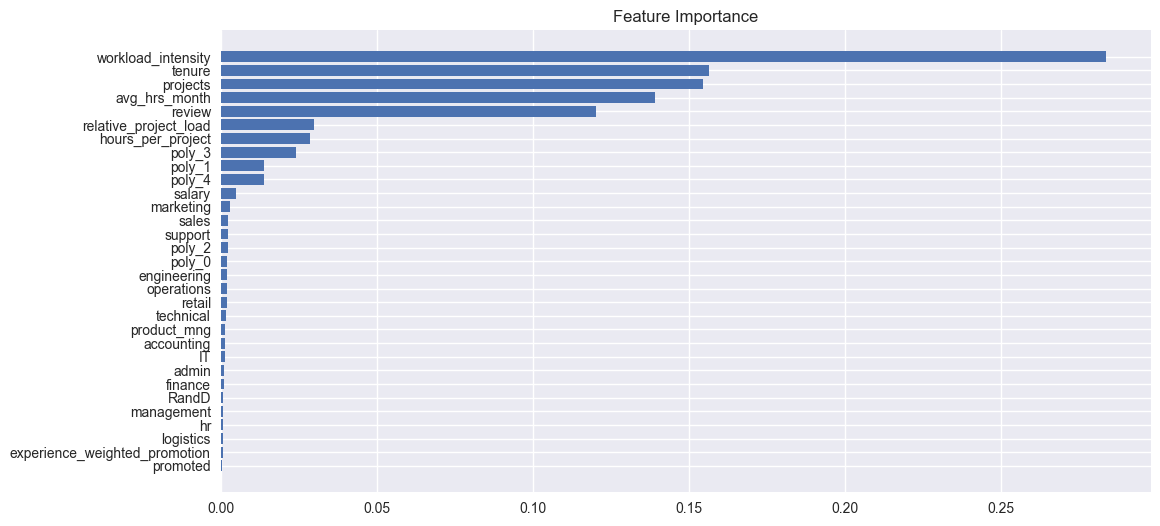

In [34]:
pipeline_rfr.fit(df_encoded[df_encoded_features], df_encoded[target])

feature_importance_rfr = pipeline_rfr.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance_rfr)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(df_encoded_features)[sorted_idx], feature_importance_rfr[sorted_idx])
plt.title('Feature Importance')

# **GBM - CatBoost**

In [35]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df_encoded[df_encoded_features], target = df_encoded[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data = scaler.fit_transform(data, target)
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 1000),
        "learning_rate": trial.suggest_float('learning_rate', 0, 1),
        "depth": trial.suggest_int('depth', 4, 16),
        "l2_leaf_reg": trial.suggest_float('l2_leaf_reg', 0, 20),
        "random_strength": trial.suggest_float('random_strength', 0, 10),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["Depthwise", "SymmetricTree", 'Lossguide'])
    }

    if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float(
            "bagging_temperature", 0, 10)
    else:
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    if param["grow_policy"] == "Depthwise":
      param["min_data_in_leaf"] = trial.suggest_int('min_data_in_leaf', 1, 100)
    elif param["grow_policy"] == 'Lossguide':
       param["max_leaves"] = trial.suggest_int('max_leaves', 1, 200)
    
    # Create and fit model
    model = CatBoostRegressor(
        loss_function = 'RMSE',
        eval_metric = "RMSE",
        random_state = 777,
        use_best_model = True,
        od_type = "Iter",
        od_wait = 25,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)],
              verbose = False)
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_cat = TPESampler(multivariate = True, group = True, seed = 777)
study_cat = optuna.create_study(study_name = "Catboost", sampler = sampler_cat)
study_cat.optimize(objective, n_trials = 200)
trial_cat = study_cat.best_trial
params_cat = study_cat.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_cat.trials))
print("Best trial:", trial_cat.number)
print("  Value: ", trial_cat.value)
print("  Params: ")

for key, value in trial_cat.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-20 06:41:48,044] A new study created in memory with name: Catboost
[I 2024-06-20 06:41:52,145] Trial 0 finished with value: 0.17837062167423118 and parameters: {'scalers': None, 'n_estimators': 935, 'learning_rate': 0.7269889843190701, 'depth': 13, 'l2_leaf_reg': 2.692050664721932, 'random_strength': 6.440292920709894, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'subsample': 0.7136013518028579}. Best is trial 0 with value: 0.17837062167423118.
[I 2024-06-20 06:41:53,973] Trial 1 finished with value: 0.17099951307881567 and parameters: {'scalers': 'minmax', 'n_estimators': 451, 'learning_rate': 0.19316240563682419, 'depth': 11, 'l2_leaf_reg': 8.82808447266879, 'random_strength': 6.223388243205817, 'bootstrap_type': 'MVS', 'grow_policy': 'Lossguide', 'subsample': 0.6403374420965867, 'max_leaves': 54}. Best is trial 1 with value: 0.17099951307881567.
[I 2024-06-20 06:41:59,533] Trial 2 finished with value: 0.173609689926542 and parameters: {'scalers': 'robust', 'n_

Number of finished trials:  150
Best trial: 124
  Value:  0.1688151406943854
  Params: 
    scalers: None
    n_estimators: 390
    learning_rate: 0.040259937415742006
    depth: 13
    l2_leaf_reg: 8.839820493192011
    random_strength: 0.13532680567510347
    bootstrap_type: Bernoulli
    grow_policy: Depthwise
    subsample: 0.5459581522765763
    min_data_in_leaf: 99


In [36]:
# History of optimization

optuna.visualization.plot_optimization_history(study_cat)

In [37]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_cat)

In [38]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_cat)

In [39]:
# Extracting the best parameters
params_cat['loss_function'] = 'RMSE'
params_cat

{'n_estimators': 390,
 'learning_rate': 0.040259937415742006,
 'depth': 13,
 'l2_leaf_reg': 8.839820493192011,
 'random_strength': 0.13532680567510347,
 'bootstrap_type': 'Bernoulli',
 'grow_policy': 'Depthwise',
 'subsample': 0.5459581522765763,
 'min_data_in_leaf': 99,
 'loss_function': 'RMSE',
 'od_type': 'Iter',
 'od_wait': 25}

In [41]:
# Implementing scaler
if params_cat['scalers'] == "minmax":
    scaler_cat = MinMaxScaler()
elif params_cat['scalers'] == "standard":
    scaler_cat = StandardScaler()
elif params_cat['scalers'] == 'maxabs':
    scaler_cat = MaxAbsScaler()
elif params_cat['scalers'] == 'robust':
    scaler_cat = RobustScaler()
else:
    scaler_cat = None

del params_cat['scalers']

if scaler_cat != None:
    cat_df_scaled = scaler_cat.fit_transform(df_encoded[df_encoded_features], df_encoded[target])

In [14]:
scaler_cat = RobustScaler()
cat_df_scaled = scaler_cat.fit_transform(df_encoded[df_encoded_features], df_encoded[target])

In [49]:
# Implementing cross validation

cat_train_data = Pool(
    data = cat_df_scaled,
    label = df_encoded[target],
)

cv_data = cv(
    pool = cat_train_data,
    params = params_cat,
    fold_count = 5,
    shuffle = True,
    partition_random_seed = 777,
    plot = True,
    stratified = True, 
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 0.177109198
bestIteration = 48

Training on fold [1/5]



bestTest = 0.1935370703
bestIteration = 171

Training on fold [2/5]



bestTest = 0.1900053585
bestIteration = 149

Training on fold [3/5]



bestTest = 0.1875863068
bestIteration = 138

Training on fold [4/5]



bestTest = 0.1898747966
bestIteration = 117



In [51]:
cv_data['test-RMSE-mean'].mean()

0.22793463358054444

In [52]:
# Creating the model with best hyperparameters

cat_model = CatBoostRegressor(
                        random_state = 777,
                        **params_cat)

cat_model.fit(cat_train_data, verbose = False)

Text(0.5, 1.0, 'Feature Importance')

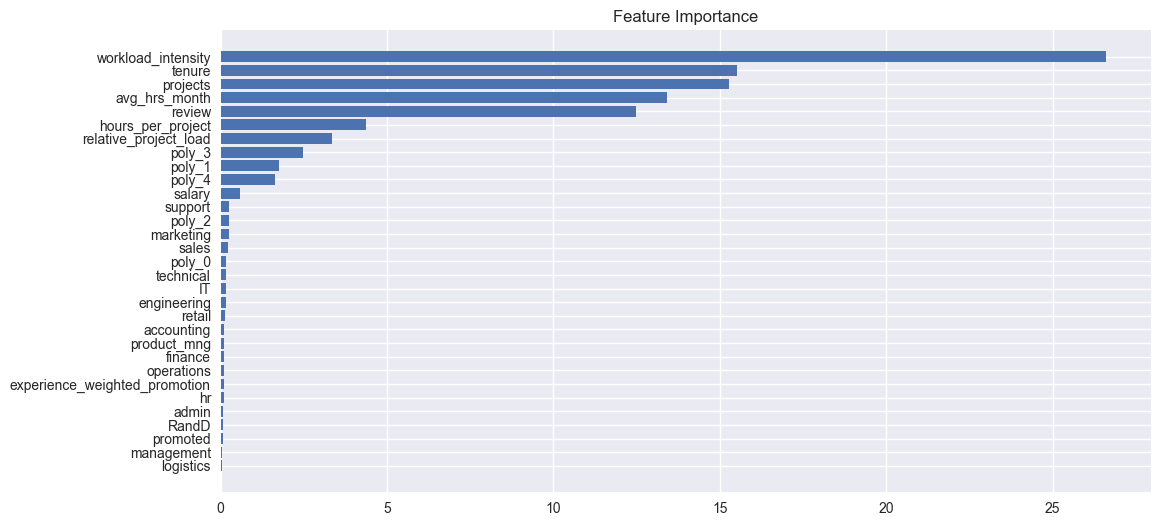

In [53]:
# Plotting feature importance

feature_importance_cat = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance_cat)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(df_encoded_features)[sorted_idx], feature_importance_cat[sorted_idx])
plt.title('Feature Importance')

# **GBM - LGBM**

In [54]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df_encoded[df_encoded_features], target = df_encoded[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data = scaler.fit_transform(data, target)
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 20.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'subsample': trial.suggest_float('subsample', 0, 1),
        'learning_rate': trial.suggest_float('learning_rate', 0, 0.5),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 200),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 300)
    }
    
    # Create and fit model
    model = LGBMRegressor(
        metric = "rmse",
        random_state = 777,
        verbosity = -1 ,
        early_stopping_rounds = 200,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)])
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_lgbm = TPESampler(multivariate = True, group = True, seed = 777)
study_lgbm = optuna.create_study(study_name = "LGBM", sampler = sampler_lgbm)
study_lgbm.optimize(objective, n_trials = 200)
trial_lgbm = study_lgbm.best_trial
params_lgbm = study_lgbm.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_lgbm.trials))
print("Best trial:", trial_lgbm.number)
print("  Value: ", trial_lgbm.value)
print("  Params: ")

for key, value in trial_lgbm.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-20 09:56:10,152] A new study created in memory with name: LGBM
[I 2024-06-20 09:56:11,132] Trial 0 finished with value: 0.17101737303471692 and parameters: {'scalers': None, 'n_estimators': 1862, 'reg_alpha': 1.3390642887323898, 'reg_lambda': 1.1857274872193933, 'colsample_bytree': 0.2692050664721932, 'subsample': 0.6440292920709894, 'learning_rate': 0.09337325682922837, 'max_depth': 5, 'num_leaves': 885, 'min_child_samples': 104, 'min_data_per_groups': 198}. Best is trial 0 with value: 0.17101737303471692.
[I 2024-06-20 09:56:12,654] Trial 1 finished with value: 0.18341391019740091 and parameters: {'scalers': 'standard', 'n_estimators': 523, 'reg_alpha': 0.006337167942572638, 'reg_lambda': 0.036525180752987024, 'colsample_bytree': 0.19316240563682419, 'subsample': 0.6109109313551226, 'learning_rate': 0.882808447266879, 'max_depth': 14, 'num_leaves': 380, 'min_child_samples': 54, 'min_data_per_groups': 164}. Best is trial 0 with value: 0.17101737303471692.
[I 2024-06-20 09:5

Number of finished trials:  150
Best trial: 39
  Value:  0.16831129188537317
  Params: 
    scalers: maxabs
    n_estimators: 1406
    reg_alpha: 4.971665971804975
    reg_lambda: 0.006840963531754233
    colsample_bytree: 0.8988931531523535
    subsample: 0.5042482092271079
    learning_rate: 0.35361694571948415
    max_depth: 9
    num_leaves: 291
    min_child_samples: 11
    min_data_per_groups: 193


In [55]:
# History of optimization

optuna.visualization.plot_optimization_history(study_lgbm)

In [56]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_lgbm)

In [57]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_lgbm)

In [58]:
# Implementing scaler
if params_lgbm['scalers'] == "minmax":
    scaler_lgbm = MinMaxScaler()
elif params_lgbm['scalers'] == "standard":
    scaler_lgbm = StandardScaler()
elif params_lgbm['scalers'] == 'maxabs':
    scaler_lgbm = MaxAbsScaler()
elif params_lgbm['scalers'] == 'robust':
    scaler_lgbm = RobustScaler()
else:
    scaler_lgbm = None

del params_lgbm['scalers']

lgbm = LGBMRegressor( 
        metric = "rmse",
        random_state = 777,
        verbosity = -1 ,
        **params_lgbm)

# Create pipeline
pipeline_lgbm = make_pipeline(scaler_lgbm, lgbm)

In [59]:
# Perform cross validation

scores_lgbm = cross_val_score(pipeline_lgbm, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_lgbm = scores_lgbm.mean()
print(scores_lgbm, "Средняя оценка:", score_mean_lgbm)

[0.16796154 0.16497147 0.16899845 0.16883691 0.1708489 ] Средняя оценка: 0.16832345477374805


In [60]:
pipeline_lgbm.fit(df_encoded[df_encoded_features], df_encoded[target])

Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('lgbmregressor',
                 LGBMRegressor(colsample_bytree=0.8988931531523535,
                               learning_rate=0.35361694571948415, max_depth=9,
                               metric='rmse', min_child_samples=11,
                               min_data_per_groups=193, n_estimators=1406,
                               num_leaves=291, random_state=777,
                               reg_alpha=4.971665971804975,
                               reg_lambda=0.006840963531754233,
                               subsample=0.5042482092271079, verbosity=-1))])

Text(0.5, 1.0, 'Feature Importance')

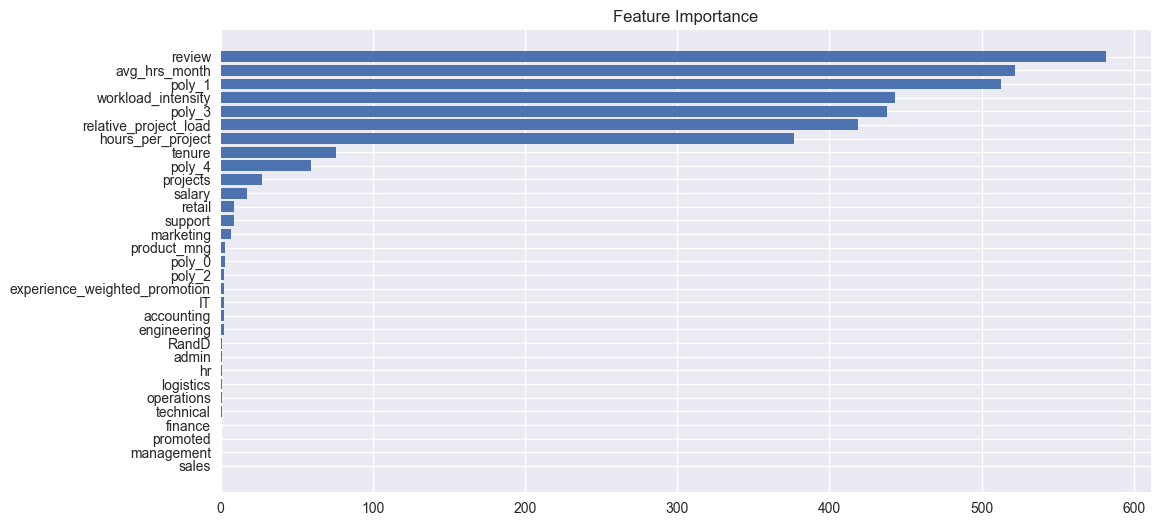

In [61]:
feature_importance_lgbm = pipeline_lgbm.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance_lgbm)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(df_encoded_features)[sorted_idx], feature_importance_lgbm[sorted_idx])
plt.title('Feature Importance')

# **GBM - XGBoost**

In [62]:
# Find best hyperparameters for Catboost using Optuna library

def objective(trial, data = df_encoded[df_encoded_features], target = df_encoded[target]):

    # Instantiate scaler
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'maxabs', None])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == 'maxabs':
        scaler = MaxAbsScaler()
    elif scalers == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    # Transform data
    if scaler != None:
        data = scaler.fit_transform(data, target)
    
    # split data in training and test data
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.25,
                                                        random_state=777)
    # Suggest hyperparameters
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 300),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 20.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'grow_policy': trial.suggest_categorical('grow_policy',
            ["depthwise", 'lossguide'])
    }
    
    # Create and fit model
    model = XGBRegressor(
        eval_metric = "rmse",
        random_state = 777,
        verbosity = 0 ,
        early_stopping_rounds = 200,
        **param
    )

    model.fit(train_x, train_y, eval_set = [(test_x, test_y)], verbose = False)
    
    # Predict and estimate results
    preds = model.predict(test_x)
    rmse = root_mean_squared_error(test_y, preds)

    return rmse



# Opruna study creation for tuning
sampler_xgbr = TPESampler(multivariate = True, group = True, seed = 777)
study_xgbr = optuna.create_study(study_name = "XGBoost", sampler = sampler_xgbr)
study_xgbr.optimize(objective, n_trials = 200)
trial_xgbr = study_xgbr.best_trial
params_xgbr = study_xgbr.best_trial.params

# Printing the parameters
print("Number of finished trials: ", len(study_xgbr.trials))
print("Best trial:", trial_xgbr.number)
print("  Value: ", trial_xgbr.value)
print("  Params: ")

for key, value in trial_xgbr.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-20 09:59:02,363] A new study created in memory with name: XGBoost
[I 2024-06-20 09:59:02,823] Trial 0 finished with value: 0.2172616748082152 and parameters: {'scalers': None, 'learning_rate': 0.9269970477498947, 'max_depth': 16, 'min_child_weight': 231, 'subsample': 0.0011934940710392116, 'colsample_bytree': 0.03768054435914761, 'gamma': 5.584522623277171e-08, 'n_estimators': 251, 'reg_alpha': 0.34351558030828316, 'reg_lambda': 0.023624474282072754, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.2172616748082152.
[I 2024-06-20 09:59:04,353] Trial 1 finished with value: 0.18467878001567373 and parameters: {'scalers': 'minmax', 'learning_rate': 0.186442600356727, 'max_depth': 10, 'min_child_weight': 58, 'subsample': 0.02777433858018924, 'colsample_bytree': 0.33980814862126696, 'gamma': 0.0009521614506087338, 'n_estimators': 581, 'reg_alpha': 0.005941356967584292, 'reg_lambda': 1.8433927643477426, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.184678780

Number of finished trials:  150
Best trial: 122
  Value:  0.16970910696397884
  Params: 
    scalers: maxabs
    learning_rate: 0.14432502195297536
    max_depth: 11
    min_child_weight: 172
    subsample: 0.7504342875853816
    colsample_bytree: 0.7141403770085071
    gamma: 4.171164861252781e-06
    n_estimators: 631
    reg_alpha: 0.0024092201886301494
    reg_lambda: 0.6902720711024989
    grow_policy: lossguide


In [63]:
# History of optimization

optuna.visualization.plot_optimization_history(study_xgbr)

In [64]:
# Hyperparameters to score dependency

optuna.visualization.plot_slice(study_xgbr)

In [65]:
# Hyperparameter importances

optuna.visualization.plot_param_importances(study_xgbr)

In [66]:
# Implementing scaler
if params_xgbr['scalers'] == "minmax":
    scaler_xgbr = MinMaxScaler()
elif params_xgbr['scalers'] == "standard":
    scaler_xgbr = StandardScaler()
elif params_xgbr['scalers'] == 'maxabs':
    scaler_xgbr = MaxAbsScaler()
elif params_xgbr['scalers'] == 'robust':
    scaler_xgbr = RobustScaler()
else:
    scaler_xgbr = None

del params_xgbr['scalers']

xgbr = XGBRegressor( 
        eval_metric = "rmse",
        random_state = 777,
        verbosity = 0 ,
        **params_xgbr)

# Create pipeline
pipeline_xgbr = make_pipeline(scaler_xgbr, xgbr)

In [67]:
# Perform cross validation

scores_xgbr = cross_val_score(pipeline_xgbr, df_encoded[df_encoded_features], df_encoded[target],  scoring = 'neg_root_mean_squared_error') * (-1)
score_mean_xgbr = scores_xgbr.mean()
print(scores_xgbr, "Средняя оценка:", score_mean_xgbr)

[0.17770041 0.17279697 0.1778712  0.1758828  0.18044983] Средняя оценка: 0.1769402431551469


Text(0.5, 1.0, 'Feature Importance')

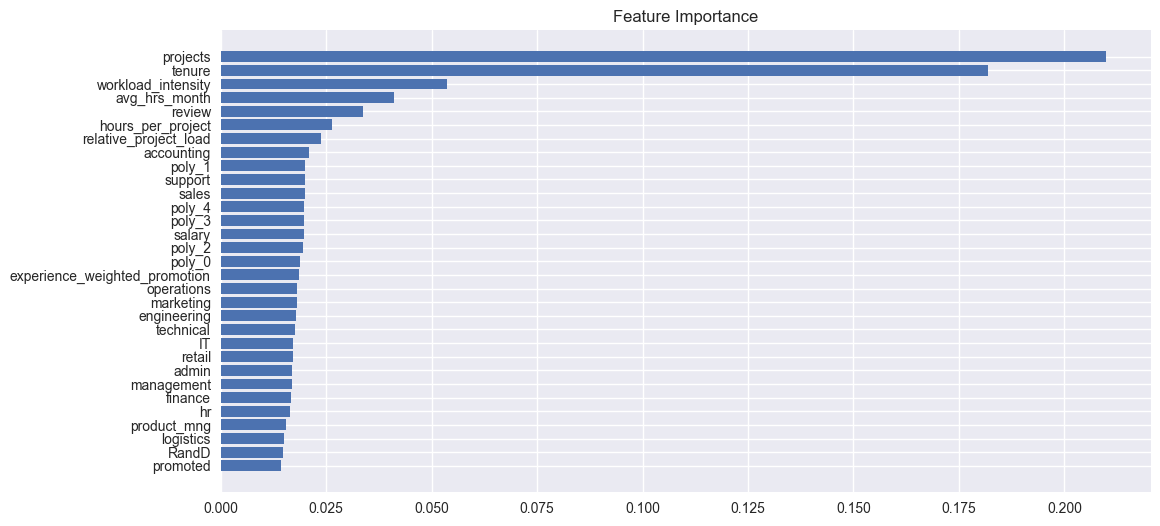

In [68]:
pipeline_xgbr.fit(df_encoded[df_encoded_features], df_encoded[target])

feature_importance_xgbr = pipeline_xgbr.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance_xgbr)

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(df_encoded_features)[sorted_idx], feature_importance_xgbr[sorted_idx])
plt.title('Feature Importance')